In [1]:
import numpy as np
import tensorflow.keras.datasets as datasets
import matplotlib.pyplot as plt

/Users/radubuzas/PycharmProjects/DigitDetection/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
mnist = datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)

(60000, 28, 28)


In [3]:
n = x_train.shape[0]
x_train = x_train.reshape(n, -1)
x_train = x_train / 255

x_test = x_test.reshape(x_test.shape[0], -1)
x_test = x_test / 255

print(x_train.shape)

(60000, 784)


In [4]:
n = x_test.shape[0]
x_test = x_test.reshape(n, -1)

print(x_test.shape)

(10000, 784)


In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [7]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [8]:
def one_hot(y):
    n = y.shape[0]
    k = np.max(y) + 1
    y_one_hot = np.zeros((n, k))
    y_one_hot[np.arange(n), y] = 1
    return y_one_hot

In [9]:
class NN:
    def __init__(self, x, y, alpha=0.01, epochs=1000, batch_size=100, architecture=(10, 10)):
        self.Z1 = None
        self.a1 = None
        self.Z2 = None
        self.a2 = None
        self.x = x
        self.y = y
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size
        self.first_layer = architecture[0]
        self.second_layer = architecture[1]
        self.W1 = np.random.randn(self.x.shape[1], self.first_layer)    # 784 x 10
        self.b1 = np.random.randn(1, self.first_layer)                # 1 x 10
        self.W2 = np.random.randn(self.first_layer, self.second_layer)
        self.b2 = np.random.randn(1, self.second_layer)


    def feedforward(self, x=None):
        if x is None:
            x = self.x
        self.Z1 = np.dot(x, self.W1) + self.b1   # n x 784 * 784 x 10 + 1 x 10 = n x 10
        self.a1 = sigmoid(self.Z1)                    # n x 10

        self.Z2 = np.dot(self.a1, self.W2) + self.b2  # n x 10 * 10 x 10 + 1 x 10 = n x 10
        self.a2 = softmax(self.Z2)                    # n x 10

    def test_iamge(self, image: np.array) -> np.array:
        self.feedforward(image)
        return np.argmax(self.a2[0])

    def backprop(self, alpha=0):
        if alpha == 0:
            alpha = self.alpha

        n = self.y.shape[0]
        one_hot_y = one_hot(self.y)

        dZ2 = self.a2 - one_hot_y
        dW2 = np.dot(self.a1.T, dZ2) / n
        db2 = np.sum(dZ2, axis=0, keepdims=True) / n

        dZ1 = np.dot(dZ2, self.W2.T) * sigmoid_derivative(self.Z1)

        dW1 = np.dot(self.x.T, dZ1) / n
        db1 = np.sum(dZ1, axis=0, keepdims=True) / n

        self.W1 -= alpha * dW1
        self.b1 -= alpha * db1
        self.W2 -= alpha * dW2
        self.b2 -= alpha * db2

    def get_accuracy(self):
        return np.mean(np.argmax(self.a2, 1) == self.y)
    #
    # def get_loss(self):
    #     n = self.y.shape[0]
    #     one_hot_y = one_hot(self.y)
    #     return -np.sum(one_hot_y * np.log(self.a2)) / n

    def SGD(self, alpha=0, epochs=0):
        if alpha == 0:
            alpha = self.alpha
        if epochs == 0:
            epochs = self.epochs
        for i in range(epochs):
            # for j in range(0, self.x.shape[0], self.batch_size):
            #     x_batch = self.x[j:j + self.batch_size]
            #     y_batch = self.y[j:j + self.batch_size]
            #     self.feedforward(x_batch)
            #     self.backprop(x_batch, y_batch)
            self.feedforward()
            self.backprop(alpha=alpha)
            if i % 10 == 0:
                print('Iteration:', i, 'Accuracy', self.get_accuracy())

In [10]:
def print_image(x):
    plt.imshow(x.reshape(28, 28), cmap='gray')

In [18]:
nn = NN(x_train, y_train, alpha=0.2, epochs=1000, batch_size=100, architecture=(10, 10))

In [30]:
# nn.SGD(alpha=5, epochs=500)
# nn.SGD(alpha=0.1, epochs=100)
nn.SGD(alpha=0.2, epochs=100)

Iteration: 0 Accuracy 0.9009666666666667
Iteration: 10 Accuracy 0.9010666666666667
Iteration: 20 Accuracy 0.9010833333333333
Iteration: 30 Accuracy 0.90115
Iteration: 40 Accuracy 0.9011666666666667
Iteration: 50 Accuracy 0.9011666666666667
Iteration: 60 Accuracy 0.9012
Iteration: 70 Accuracy 0.9011666666666667
Iteration: 80 Accuracy 0.9012166666666667
Iteration: 90 Accuracy 0.9012833333333333


In [12]:
# get random image
def get_random_image(nn: NN):
    i = np.random.randint(0, x_test.shape[0])
    x = x_test[i].reshape(1, -1)
    print_image(x)

    print('Image:', i)
    print('Actual:', y_test[i])
    print('Predicted:', nn.test_iamge(x))

Image: 7559
Actual: 5
Predicted: 3


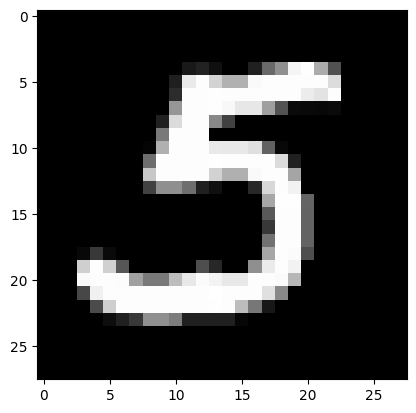

In [81]:
get_random_image(nn)

In [41]:
def feedforward(nn: NN, x: np.array) -> np.array:
    nn.Z1 = np.dot(x, nn.W1) + nn.b1
    nn.a1 = sigmoid(nn.Z1)

    nn.Z2 = np.dot(nn.a1, nn.W2) + nn.b2
    nn.a2 = softmax(nn.Z2)
    return nn.a2


In [14]:
feedforward(nn)

(60000, 10)
(60000, 10)
(60000, 10)
(60000, 10)
[[0.07822789 0.15085618 0.15128491 0.2211937  0.04773205 0.12042985
  0.06278827 0.07870149 0.06725835 0.02152731]
 [0.28981819 0.02442793 0.0324325  0.04108263 0.08800018 0.30865397
  0.03566433 0.01883071 0.12872013 0.03236942]
 [0.05216619 0.05143023 0.04176863 0.03838737 0.22581421 0.04926562
  0.107156   0.07268938 0.26262586 0.09869651]
 [0.00782923 0.74145443 0.04338245 0.07906384 0.01036192 0.01163253
  0.00893974 0.07685359 0.00759007 0.0128922 ]
 [0.06704959 0.05582989 0.01891781 0.01473907 0.24909311 0.05163518
  0.03917211 0.12753145 0.17702474 0.19900706]
 [0.04771459 0.09606123 0.33857354 0.26732514 0.00835676 0.0303484
  0.09636847 0.06352128 0.00992303 0.04180756]
 [0.08838369 0.45648168 0.03773618 0.02733895 0.06986745 0.0506123
  0.01392985 0.14803763 0.04243057 0.06518169]
 [0.03651886 0.04305334 0.22572559 0.18644727 0.06779873 0.07078926
  0.17594933 0.07334568 0.07958741 0.04078454]
 [0.20237366 0.37646815 0.0568589 

0.3633166666666667

In [15]:
print(one_hot(y_train).shape)

(60000, 10)


In [16]:
nn.Z1 = np.dot(nn.x, nn.W1) + nn.b1   # n x 784 * 784 x 10 + 1 x 10 = n x 10
nn.a1 = sigmoid(nn.Z1)                    # n x 10

print(nn.a1.shape)

nn.Z2 = np.dot(nn.a1, nn.W2) + nn.b2  # n x 10 * 10 x 10 + 1 x 10 = n x 10
nn.a2 = softmax(nn.Z2)                    # n x 10

print(nn.a2.shape)

(60000, 10)
(60000, 10)
